# This is a notebook where I show you what data is available for analysis, roughly how it is formatted, and how to make a few plots
## It is meant to be a "jump start" for your own exploration of the data

## Resources
### Paper
doi.org/10.1126/science.aay4199
### Preprint 
https://www.biorxiv.org/content/10.1101/675314v1
### Github and archived Zenodo of the pipeline to get from raw reads to the processed data available here
https://github.com/mjohnson11/TnSeq_Pipeline and https://zenodo.org/record/3402230#.Xc3brpNKhTY
(this notebook is essentially a simplified version of the one in these repositories used to make the paper figures)

## Requirements
I think just a normal anaconda distribution of python should be fine for everythong here, which you probably already have: https://www.anaconda.com/distribution/

## Importing various useful libraries / setting up plotting

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
colors = ['#FFB000', '#648FFF']
%matplotlib notebook

# Reading data:

In [2]:
## READING DATA
def change_well_format(w):
    if '_' in w:
        plate = int(w[1:3])
        t = 'LK' + str(plate) + '-'
        n = int(w.split('_')[1])
        lets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        l = lets[int(np.floor((n-1)/12))]
        return t + l + str(((n-1) % 12) + 1).zfill(2)
    else:
        return w

def get_geno_matrix(seg_names):
    # Data from https://www.nature.com/articles/nature11867, can also be dowloaded here http://genomics-pubs.princeton.edu/YeastCross_BYxRM/
    d = pd.read_csv('files/BYxRM_GenoData.csv') 
    map_genos = {'B': 0, 'R': 1}
    for w in d.keys():
        if change_well_format(w) in seg_names:
            d[change_well_format(w)] = d[w].map(map_genos)
    assert len([s for s in seg_names if s in d.columns]) == len(seg_names)
    return d[['marker'] + seg_names]


# Reading information of segregant fitness in our focal environment (from Jerison et al. 2017)
x_info = pd.read_csv('files/Clones_For_Tn96_Experiment.csv')
seg_to_fit = {i[0]: i[1] for i in x_info.as_matrix(['segregant', 'initial fitness, YPD 30C'])}
# Reading data files containing fitness effect information from the small library experiment (few (~100) mutations in many genetic backgrounds)
tp_all = pd.read_csv('files/TP_data_by_edge.csv')
# This excludes the neutral controls, a few mutations that were unintentionally included in this library, and a few controls that didn't end up getting good enough coverage to really analyze
tp = tp_all.loc[tp_all['Type']=='Experiment']
# Reading same thing for large library experiment (many mutations in a few genetic backgrounds)
bt = pd.read_csv('files/BT_data_by_edge.csv')
# Reading aggregate data on DFE (distribution of fitness effect) data statistics for each segregant
tp_dfe = pd.read_csv('files/TP_DFE_statistics.csv')
bt_dfe = pd.read_csv('files/BT_DFE_statistics.csv')
# For bioinformatic reasons, the BT (large library) data has a longer edge sequence, changing so the two exps are comparable
bt['Long.Edge'] = bt['Edge']
bt['Edge'] = bt['Long.Edge'].str[:15]
# Making a few dictionaries that point from the names I am used to to the dataframes
dats = {'BT': bt, 'TP': tp, 'BT.DFE': bt_dfe, 'TP.DFE': tp_dfe}
exps = {'BT': 'E1', 'TP': 'E2'}
# Getting a list of segregants in each experiment by looking for columns like segregant.mean.s in the dataframe
segs_all = {exp: [i.split('.')[0] for i in dats[exp] if '.mean.s' in i] for exp in exps}
# Getting genotype information on these segregants using data from Bloom et al. 2013
gm = get_geno_matrix(segs_all['TP'])
# Making restricted lists of segregants that have at least 50 mutations with s measured for DFE comparisons
segs_use = {exp: [s for s in segs_all[exp] if len(dats[exp].loc[pd.notnull(dats[exp][s + '.mean.s'])])>=50] for exp in exps}
# Making some 
sorted_segs = {exp: sorted(segs_use[exp], key=lambda x: seg_to_fit[x]) for exp in exps}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# Let's just take a look at all this data, to see what's what
for tp and bt, each row is a mutation
for tp_dfe and bt_dfe, each row is a DFE statistic (or background fitness, which we can treat similarly)
for gm, each row is a genotyped allele that is different between RM and BY (and takes each state in ~half the segregants)

In [3]:
tp.iloc[:3]

,Edge,Type,Edge.ID,Gene.Use,Gene_ORF,Gene_ORF.nearby,briefDescription,briefDescription.nearby,chromosome,description,...,full_model_p,full_model_aic,full_model_r2_95_conf_low,full_model_r2_95_conf_high,full_model_p_values,full_model_params,full_model_coeffs,qtls,resid.qtls,full.model.qtls
0,TGATCATCACGGGAC,Experiment,888,in FLC2,FLC2,FLC2,Putative calcium channel involved in calcium r...,Putative calcium channel involved in calcium r...,chr01,Putative calcium channel involved in calcium r...,...,8.990535e-25,-1049.391200,0.484313,0.664302,3.3295688484889364e-32;1.8707009014831425e-05;...,x;locus_9649106_chr14_401893_C_T;locus_9717516...,-0.009667588479105496;-0.06737728192983725;0.3...,chr14_401893;chr14_374661;chr14_402771,chr14_470303;chr14_420065;chr14_492376,chr14_401893;chr14_374661;chr14_402771|chr14_4...
1,TCGAAAGCACAGTAG,Experiment,377,nearby SRB2,NaN,SRB2,NaN,Subunit of the RNA polymerase II mediator complex,chr08,NaN,...,5.640931e-01,-83.796365,0.000082,0.396975,0.00020013790535836575;0.5640930907526316,x,-0.049382849134784586;-0.08592702839231847,NaN,NaN,NaN
2,GTTGAACTGGTTGTT,Experiment,197,in STM1,STM1,STM1,Protein required for optimal translation under...,Protein required for optimal translation under...,chr12,Protein required for optimal translation under...,...,2.500225e-07,-803.596564,0.103969,0.347860,1.4054000123711754e-50;0.9145877127045838;4.10...,x;locus_9680363_chr14_433150_G_A,-0.028546289780384954;-0.0024826738390553073;0...,chr14_433150;chr14_420065;chr14_485550,chr14_433150;chr14_420065;chr14_492376,chr14_433150;chr14_420065;chr14_485550


In [4]:
bt.iloc[:3]

,Edge.ID,Edge,Gene.Use,Gene_ORF,Gene_ORF.nearby,briefDescription,briefDescription.nearby,chromosome,description,description.nearby,...,full_model_r2,full_model_p,full_model_aic,full_model_p_values,full_model_params,full_model_coeffs,qtls,resid.qtls,full.model.qtls,Long.Edge
0,0,TCTCCAAGGGATACT,in YMR085W,YMR085W,YMR085W,Putative protein of unknown function,Putative protein of unknown function,chr13,Putative protein of unknown function; YMR085W ...,Putative protein of unknown function; YMR085W ...,...,0.010223,0.781072,-80.547553,0.26814250806982043;0.7810722126668491,x,0.001490528225059142;0.006953626038516742,NaN,NaN,NaN,TCTCCAAGGGATACTTAACGTTATTCCTTT
1,1,TGTGTCGATTTAGTG,in RKM3,RKM3,RKM3,Ribosomal lysine methyltransferase,Ribosomal lysine methyltransferase,chr02,Ribosomal lysine methyltransferase; specific f...,Ribosomal lysine methyltransferase; specific f...,...,0.030625,0.567432,-114.446981,0.15944797128735522;0.5674322326468317,x,0.001162120166529229;-0.009006462611979207,NaN,NaN,NaN,TGTGTCGATTTAGTGTTAAAGAATGACGTC
2,2,TATGGTGCAGAAAAG,nearby YNL143C,NaN,MEP2|YNL143C,NaN,Ammonium permease involved in regulation of ps...,chr14,NaN,Ammonium permease involved in regulation of ps...,...,0.144110,0.132863,-171.801874,0.10689612722798757;0.13286265303302433,x,0.0006108064927804045;0.012645873311052722,NaN,NaN,NaN,TATGGTGCAGAAAAGTGGCTCGGAATGAAC


In [5]:
tp_dfe.iloc[:3]

,DFE.statistic,LK4-G06,LK3-G08,LK2-G07,LK4-H03,LK4-D11,LK3-E06,LK1-D12,LK6-C05,LK4-C09,...,full_resid_seg_model_r2,full_resid_seg_model_p,full_resid_seg_model_r2_95_conf_low,full_resid_seg_model_r2_95_conf_high,full_resid_seg_model_p_values,full_resid_seg_model_params,full_resid_seg_model_coeffs,qtls,resid.qtls,full.model.qtls
0,background.fitness,0.017536,0.093806,-0.019195,0.022961,-0.060829,0.032745,-0.057404,-0.059662,-0.087799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr14_381891;chr14_368185;chr14_393024|chr15_1...,NaN,chr14_381891;chr14_368185;chr14_393024|chr15_1...
1,mean,-0.021606,-0.038078,-0.022692,-0.033220,-0.011229,-0.026932,-0.010239,-0.010303,-0.016691,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr14_381891;chr14_371959;chr14_393024|chr04_4...,chr14_459667;chr14_414983;chr14_481897,chr14_381891;chr14_371959;chr14_393024|chr04_4...
2,median,-0.017210,-0.022665,-0.012889,-0.025198,-0.012115,-0.016404,-0.010974,-0.009748,-0.010328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr14_376315;chr14_368185;chr14_393024,chr14_433150;chr14_414983;chr14_485550,chr14_376315;chr14_368185;chr14_393024|chr14_4...


In [6]:
bt_dfe.iloc[:3]

,DFE.statistic,LK4-A04,LK3-D08,LK3-G02,LK2-F11,LK1-E09,LK4-E02,LK1-C09,LK2-A12,LK4-H11,...,full_resid_seg_model_r2,full_resid_seg_model_p,full_resid_seg_model_r2_95_conf_low,full_resid_seg_model_r2_95_conf_high,full_resid_seg_model_p_values,full_resid_seg_model_params,full_resid_seg_model_coeffs,qtls,resid.qtls,full.model.qtls
0,background.fitness,0.036559,0.023625,-0.021251,0.035349,0.001306,-0.021838,0.097835,-0.029612,-0.043350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mean,-0.005015,-0.005416,-0.003760,-0.004865,-0.002509,-0.003774,-0.003754,-0.002583,-0.003060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,median,0.001086,0.000173,0.000602,0.000504,0.000646,0.000713,0.000439,0.000787,0.000182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
gm.iloc[:3]

,marker,LK4-G06,LK3-G08,LK2-G07,LK4-A04,LK4-H03,LK4-D11,LK3-E06,LK1-D10,LK1-D12,...,LK2-D09,LK1-D06,LK3-A01,LK2-D05,LK1-C11,LK1-G03,LK3-D04,LK3-C06,LK2-A01,LK2-G10
0,27915_chr01_27915_T_C,1,0,1,1,0,0,0,1,1,...,0,0,1,0,1,0,1,1,1,1
1,28323_chr01_28323_G_A,1,0,1,1,0,0,0,1,1,...,0,0,1,0,1,0,1,1,1,1
2,28652_chr01_28652_G_T,1,0,1,1,0,0,0,1,1,...,0,0,1,0,1,0,1,1,1,1


## Here are some basic statistics on the data from the two experiments:

In [8]:
tp_seg_edges_measured = [len(tp.loc[pd.notnull(tp[s+'.mean.s'])]) for s in segs_all['TP']]
bt_seg_edges_measured = [len(bt.loc[pd.notnull(bt[s+'.mean.s'])]) for s in segs_all['BT']]

In [9]:
print('BT. Tried 20 segregants.')
print(len(segs_all['BT']), ' segregants included.', np.mean(bt_seg_edges_measured), 'mutations measured on average,', 'min:', np.min(bt_seg_edges_measured), 'max:', np.max(bt_seg_edges_measured))
print(len(bt), 'mutations.', len(bt.loc[bt['num.measured']>0]), 'measured in at least one seg.', 'of those, they are measured in', np.mean(bt.loc[bt['num.measured']>0]['num.measured']), 'on average.')
print('Measured in', np.nanmean(bt.loc[bt['num.measured']>0]['num.measured']), 'segs on average')
print(len(bt.loc[bt['num.sig']>0]), 'significant in at least one seg,', len(bt.loc[bt['num.measured']>0].loc[bt['num.sig']==0]), 'in none,', 
      len(bt.loc[bt['num.measured']>0].loc[bt['num.sig']==0])/len(bt.loc[bt['num.measured']>0]), 'percent')

BT. Tried 20 segregants.
18  segregants included. 413.8888888888889 mutations measured on average, min: 180 max: 614
996 mutations. 710 measured in at least one seg. of those, they are measured in 10.492957746478874 on average.
Measured in 10.492957746478874 segs on average
253 significant in at least one seg, 457 in none, 0.643661971830986 percent


In [10]:
print('TP. Tried 176 segregants.')
print(len(segs_all['TP']), ' segregants included.', np.mean(tp_seg_edges_measured), 'mutations measured on average,', 'min:', np.min(tp_seg_edges_measured), 'max:', np.max(tp_seg_edges_measured))
print(len(tp), 'mutations.', 'Measured in', np.nanmean(tp['num.measured']), 'segs on average')
print(np.min(tp['num.measured']),'is the minimum # segs w measurements for one mutation, and the min # sig effects is:', np.min(tp['num.sig']))

TP. Tried 176 segregants.
162  segregants included. 65.70987654320987 mutations measured on average, min: 1 max: 82
91 mutations. Measured in 116.97802197802197 segs on average
9 is the minimum # segs w measurements for one mutation, and the min # sig effects is: 0


## Additional columns in these datasets describe the results of the modeling described in the paper, in terms of the R^2, AIC, etc. for various models of epistasis, the models are background fitness (x), QTLs (qtl), full (both), or resid versions (resid_qtl is the qtl model after regressing out x effects), and the columns like:

In [11]:
print([i for i in tp if 'aic' in i or i[-2:] in ['r2', '_p']])

['x_model_r2', 'x_model_p', 'x_model_aic', 'qtl_model_r2', 'qtl_model_p', 'qtl_model_aic', 'resid_qtl_model_r2', 'resid_qtl_model_p', 'resid_qtl_model_aic', 'resid_x_model_r2', 'resid_x_model_p', 'resid_x_model_aic', 'full_model_r2', 'full_model_p', 'full_model_aic']


# Plot fitness effect vs. background fitness for a particular mutation

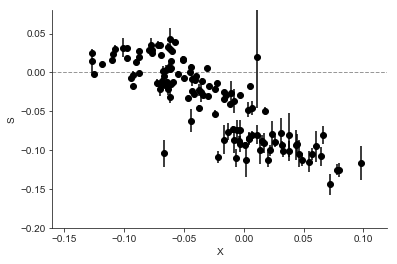

In [12]:
def plot_simple(sub, df_row, segs):
    measured = [seg for seg in segs if pd.notnull(df_row[seg + '.mean.s'])]
    xs = [seg_to_fit[measured[s]] for s in range(len(measured))]
    ys = [df_row[measured[s] + '.mean.s'] for s in range(len(measured))]
    ye = [df_row[measured[s] + '.stderr.s'] for s in range(len(measured))]
    sub.axhline(y=0, xmin=0, xmax=1, color='#333333', linestyle='dashed', alpha=0.5, lw=1)
    sub.errorbar(x=xs, y=ys, yerr=ye, marker='o', c='k', linestyle='')   
    sub.set_xlim([-0.16, 0.12])
    sub.set_ylim([-0.2, 0.08])
    sub.set_xlabel('X')
    sub.set_ylabel('S')
    sns.despine()

f, sub = pl.subplots(1,1)
dataframe_row = tp[tp['Gene.Use']=='in RPL16A'].iloc[0]
plot_simple(sub, dataframe_row, segs_use['TP'])

# Plot a couple DFEs
Note in the paper we plot combined DFEs by background fitness quartiles to make them less noisey, which is why this is different:

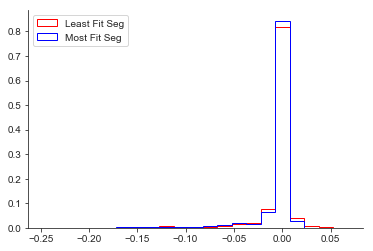

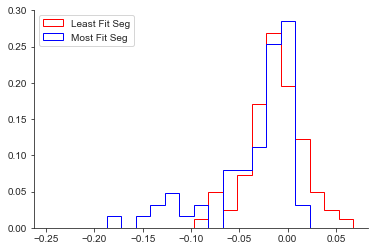

In [13]:
def get_dfe(df, segname):
    use_df = df.loc[pd.notnull(df[segname + '.mean.s'])]
    return list(use_df[segname + '.mean.s'])

def simple_plot_dfe_compare(exp):
    f, sub = pl.subplots(1, 1, figsize=(6, 4))
    lowest_fit_dfe = get_dfe(dats[exp], sorted_segs[exp][0])
    highest_fit_dfe = get_dfe(dats[exp], sorted_segs[exp][-1])
    bin_lefts = [(-16.15+i)*0.015-0.005 for i in range(22)]
    sub.hist(lowest_fit_dfe, bins=bin_lefts, label='Least Fit Seg', histtype="step", color="r", weights=np.ones_like(lowest_fit_dfe)/float(len(lowest_fit_dfe)))
    sub.hist(highest_fit_dfe, bins=bin_lefts, label='Most Fit Seg', histtype="step", color="b", weights=np.ones_like(highest_fit_dfe)/float(len(highest_fit_dfe)))
    sub.legend(loc='upper left')
    sns.despine()
    
simple_plot_dfe_compare('BT')
simple_plot_dfe_compare('TP')

# OK that concludes the jump-start! 

If you want to get deeper into the plotting / data exploration you can also check out the (much longer but less well commented) jupyter notebook on https://github.com/mjohnson11/TnSeq_Pipeline

Please email me if you have questions: milo.s.johnson.13@gmail.com
